In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 0.1.dev19174+g56b5bdf 
Supposed to be 1.0 (21-12-2022)


In [2]:
import sys
import astropy.units as u
import gammapy
import matplotlib.pylab as plt
import numpy as np
import pyximport
import yaml
from gammapy.datasets import FluxPointsDataset
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from gammapy.modeling import Fit, Parameter, Parameters
from gammapy.modeling.models import Models, FoVBackgroundModel, Model
from matplotlib import rc
from scipy.interpolate import interp2d

# import random
sys.path.append("/home/katrin/Documents/nuisance_summary/")
sys.path.append("../")
import Dataset_load  # noqa: E402
from Dataset_Creation import sys_dataset  # noqa: E402

print(f"loaded gammapy version: {gammapy.__version__} ")
print("Supposed to be 1.0 (21-12-2022)")
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)
pyximport.install()

loaded gammapy version: 0.1.dev19174+g56b5bdf 
Supposed to be 1.0 (21-12-2022)


(None, <pyximport.pyximport.PyxImporter at 0x7f69bc5d0820>)

## Create dataset

In [3]:
scaled_amplitude = Parameter("amplitude", value=1e-12)
dataset_asimov = Dataset_load.create_asimov(
    model="pl", source="PKSflare", parameters=Parameters([scaled_amplitude])
)

shift = 0.1
tilt = 0.02

sys_ = sys_dataset(
    dataset_asimov=dataset_asimov,
    shift=0,
    tilt=0,
    bias=0,
    resolution=0,
    rnd=False,
    e_reco_creation=10,
)
dataset_asimov = sys_.create_dataset()
dataset_input = sys_.create_dataset()
dataset_asimov_N = sys_.create_dataset_N(e_reco_n=10)
zero = 1e-24
# addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
# 'bias', 'resolution', 'norm_nuisance',  'tilt_nuisance',
np.fill_diagonal(
    penalising_invcovmatrix,
    [1 / zero**2, 1 / zero**2, 1 / shift**2, 1 / tilt**2],
)
dataset_asimov_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_asimov_N.irf_model.e_reco_model.parameters.freeze_all()
dataset_asimov_N.irf_model.parameters["tilt_nuisance"].frozen = False

a_unit = dataset_asimov_N.models.parameters["amplitude"].unit



loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-pl.fits.gz


In [4]:
%%time
fitting = 1
if fitting :
    fit = Fit(store_trace=False)
    minuit_opts = {"tol": 0.001, "strategy": 2}
    fit.optimize_opts = minuit_opts
    result = fit.run(dataset_asimov)
    fit_N = Fit(store_trace=False)
    fit_N.optimize_opts = minuit_opts
    result_N = fit_N.run(dataset_asimov_N)

else:
    m  = Models.read("data/1_model_cor.yml")
    dataset_asimov.models = Models([m[0], FoVBackgroundModel(dataset_name=dataset_asimov.name), ])
    path = f"data/2_model_nui_{0.0}_tilt_{0}.yml"
    dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path)
    dataset_asimov_N.models.parameters["tilt_nuisance"].frozen = False


CPU times: user 5min 2s, sys: 7min 58s, total: 13min
Wall time: 3min 11s


In [5]:
mask = dataset_asimov.mask.data[:,200,200]
ebins = dataset_asimov.counts.geom.axes[0].center[mask]
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV

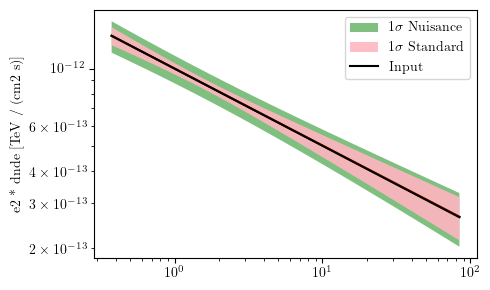

In [6]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV
fig, axs = plt.subplots(1,1, figsize = (5,3))

dataset_asimov_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs,
                                label = "", color = "green")    

dataset_asimov_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Nuisance", facecolor = "green", alpha = 0.5)    
    
dataset_asimov.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs,
                                label = "", color = "red", alpha = 0.9)    

dataset_asimov.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Standard", facecolor = "lightpink",
                                                   alpha = 0.9)

dataset_input.models[0].spectral_model.plot(energy_bounds, linestyle='-', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )

axs.set_xlabel('')
axs.legend()
plt.tight_layout()


## Compute Asimov Fluxpoints


In [7]:
comput_fp = 1
if comput_fp :
    energy_edges = dataset_asimov.geoms["geom"].axes[0].edges[::2]
    esti = FluxPointsEstimator(energy_edges=energy_edges)
    fluxpoints = esti.run([dataset_asimov])
    fluxpoints.write(
        "data/fluxpoints/6_fluxpoints_asimov.fits", overwrite = True
    )
    Models([dataset_asimov.models[0]]).write(
        "data/fluxpoints/6_model_asimov.fits" , overwrite = True
    )
    
    fluxpoints_N = esti.run([dataset_asimov_N])
    fluxpoints_N.write(
        f"data/fluxpoints/6_fluxpoints_asimov_N.fits", overwrite= True,
    )
    Models([dataset_asimov_N.models[0]]).write(
        f"data/fluxpoints/6_model_asimov_N.fits", overwrite= True,
    )
    
    fp_asimov = FluxPointsDataset(data = fluxpoints, models = Models([dataset_asimov.models[0]]))
    fp_asimov_N = FluxPointsDataset(data = fluxpoints_N, models = Models([dataset_asimov_N.models[0]]))
    
else:
    fp_asimov = FluxPointsDataset(data = FluxPoints.read("data/fluxpoints/6_fluxpoints_asimov.fits"),
                                 models = Models.read("data/fluxpoints/6_model_asimov.fits"))
    fp_asimov_N = FluxPointsDataset(data = FluxPoints.read("data/fluxpoints/6_fluxpoints_asimov_N.fits"),
                                 models = Models.read("data/fluxpoints/6_model_asimov_N.fits"))


0.10000000000000002 TeV 0.1778279410038923 TeV
norm 1.0 0

0.1778279410038923 TeV 0.316227766016838 TeV
norm 1.0 0

0.316227766016838 TeV 0.5623413251903491 TeV
norm 1.0025175724466786 0.13917482585972074

0.5623413251903491 TeV 1.0 TeV
norm 0.9997312740000895 0.09228515702437542

1.0 TeV 1.7782794100389232 TeV
norm 0.9995483657316848 0.09312300424427954

1.7782794100389232 TeV 3.1622776601683795 TeV
norm 0.9990120999372533 0.11348885449572423

3.1622776601683795 TeV 5.623413251903489 TeV
norm 0.9985322893191354 0.14575349768353552

5.623413251903489 TeV 10.000000000000002 TeV
norm 0.9980192810656057 0.19256731078156536

10.000000000000002 TeV 17.78279410038923 TeV
norm 0.997554916711728 0.2558267071154707

17.78279410038923 TeV 31.62277660168379 TeV
norm 0.9964393001882287 0.34247382300532697

31.62277660168379 TeV 56.234132519034915 TeV
norm 0.9962297850596868 0.4833090443918406

56.234132519034915 TeV 100.00000000000004 TeV
norm 1.0787882086705214 0.7789209248192492

0.100000000000

In [8]:
def plot_shifted (ff, shift):
    return ff.energy_ref* shift, ff.e2dnde.data[:,0,0],  ff.e2dnde_err.data[:,0,0], 

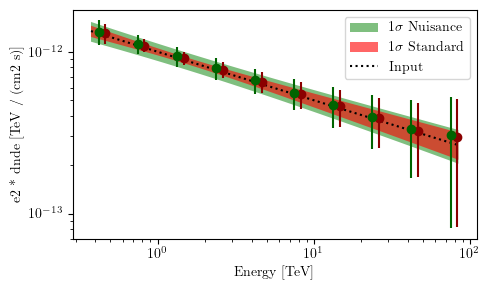

In [9]:
fig, axs = plt.subplots(1,1, figsize = (5,3))
dataset_asimov_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Nuisance", facecolor = "green", alpha = 0.5)    
    
dataset_asimov.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Standard", facecolor = "red", alpha = 0.6)

dataset_input.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )



e_, f_, ferr_ = plot_shifted(fp_asimov.data, 1.1)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkred', fmt='o')  

e_, f_, ferr_ = plot_shifted(fp_asimov_N.data, 1.)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkgreen', fmt='o')  


axs.legend()
plt.tight_layout()


/home/wecapstor1/caph/mppi045h/gammapy/gammapy/maps/region/ndmap.py:113: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/maps/region/ndmap.py:113: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "x" (-> marker='x'). The keyword argument will take precedence.
  ax.errorbar(


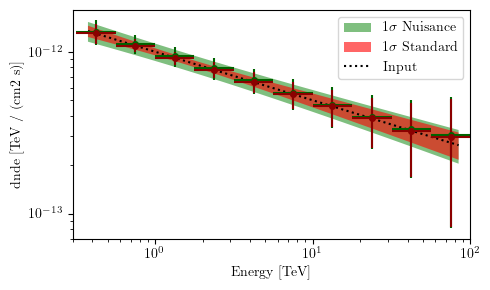

In [10]:
fig, axs = plt.subplots(1,1, figsize = (5,3))
dataset_asimov_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Nuisance", facecolor = "green", alpha = 0.5)    
    
dataset_asimov.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Standard", facecolor = "red", alpha = 0.6)

dataset_input.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )





fp_asimov_N.data.plot(energy_power =2,  color = 'darkgreen', fmt='o')  
fp_asimov.data.plot(energy_power =2,  color = 'darkred', fmt='x')  

axs.set_xlim(0.3, 100)
axs.legend()
plt.tight_layout()
